In [19]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import catboost as cb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sentence_transformers import SentenceTransformer

In [2]:
# Load data with selected columns

file_path = '/kaggle/input/listing/listings.csv'
raw_df = pd.read_csv(file_path, low_memory=False)

features_to_use = [
    'id', 'price', 'neighbourhood_cleansed', 'property_type', 'room_type',
    'amenities', 'host_since', 'last_review', 'accommodates', 'bathrooms_text',
    'bedrooms', 'beds', 'calculated_host_listings_count', 'has_availability',
    'host_acceptance_rate', 'host_has_profile_pic', 'host_identity_verified',
    'host_is_superhost', 'host_listings_count', 'instant_bookable', 'latitude',
    'longitude', 'minimum_nights', 'number_of_reviews_ltm',
    'review_scores_cleanliness', 'review_scores_location',
    'review_scores_rating', 'reviews_per_month', 'name', 'neighborhood_overview',
    'host_about', 'description', 'estimated_occupancy_l365d',
    'estimated_revenue_l365d', 'availability_365', 'availability_90',
    'availability_60', 'availability_30'
]

feature_df = raw_df[features_to_use].copy()

In [3]:
# Clean the target variable 'price' and remove duplicate rows
print(f"Initial row count: {len(feature_df)}")

num_duplicates = feature_df.duplicated().sum()
if num_duplicates > 0:
    feature_df.drop_duplicates(inplace=True)
print(f"Removed {num_duplicates} duplicate rows.")

if feature_df['price'].dtype == 'object':
    feature_df['price'] = feature_df['price'].replace({r'\$': '', r',': ''}, regex=True).astype(float)

rows_before_price_filter = len(feature_df)
invalid_price_mask = (feature_df['price'] <= 0) | (feature_df['price'].isnull())
feature_df = feature_df[~invalid_price_mask]
rows_removed = rows_before_price_filter - len(feature_df)
print(f"Removed {rows_removed} rows with invalid prices (null or zero).")

print(f"Final row count after cleaning: {len(feature_df)}")

Initial row count: 94559
Removed 0 duplicate rows.
Removed 34218 rows with invalid prices (null or zero).
Final row count after cleaning: 60341


In [4]:
# Drop complex text and categorical columns for the initial data cleaning
cols_to_drop = [
    'name', 'neighborhood_overview', 'host_about', 'description', 'bathrooms_text',
    'neighbourhood_cleansed', 'property_type', 'room_type', 'amenities'
]
feature_df.drop(columns=cols_to_drop, inplace=True)

In [5]:
# Assess and display a summary of missing values
missing_values = feature_df.isnull().sum()
missing_percent = (missing_values / len(feature_df)) * 100

missing_summary = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percent
})

display(missing_summary[missing_summary['Missing Count'] > 0].sort_values(by='Missing Percentage', ascending=False))

complete_rows = feature_df.dropna().shape[0]
print(f"\nRow Completeness: {complete_rows} of {len(feature_df)} rows are complete.")

,Missing Count,Missing Percentage
review_scores_location,13932,23.088779
review_scores_cleanliness,13931,23.087122
review_scores_rating,13928,23.082150
reviews_per_month,13928,23.082150
last_review,13928,23.082150
host_acceptance_rate,4891,8.105600
host_is_superhost,1394,2.310204
has_availability,799,1.324141
bedrooms,113,0.187269
beds,105,0.174011



Row Completeness: 43343 of 60341 rows are complete.


In [6]:
# Engineer review-related features and handle associated missing values
inconsistent_rows_mask = feature_df['last_review'].notnull() & (
    feature_df['review_scores_rating'].isnull() |
    feature_df['review_scores_cleanliness'].isnull() |
    feature_df['review_scores_location'].isnull()
)
if inconsistent_rows_mask.sum() > 0:
    feature_df = feature_df[~inconsistent_rows_mask]

# Create 'is_unreviewed' flag and impute related numerical columns with 0
feature_df['is_unreviewed'] = feature_df['last_review'].isnull().astype(int)
review_score_cols = ['review_scores_rating', 'review_scores_cleanliness', 'review_scores_location']
feature_df['reviews_per_month'].fillna(0, inplace=True)
feature_df[review_score_cols] = feature_df[review_score_cols].fillna(0)

# Engineer 'days_since_last_review' and drop the original date column
scrape_date = pd.to_datetime('2025-03-04')
feature_df['last_review'] = pd.to_datetime(feature_df['last_review'], errors='coerce')
feature_df['last_review'].fillna(scrape_date, inplace=True)
feature_df['days_since_last_review'] = (scrape_date - feature_df['last_review']).dt.days
feature_df.drop(columns=['last_review'], inplace=True)

print("Engineered review features and handled missing values.")

Engineered review features and handled missing values.


In [7]:
# Impute or drop remaining missing values
print(f"Initial row count: {len(feature_df)}")

# Impute 'host_acceptance_rate' with its median value
if feature_df['host_acceptance_rate'].dtype == 'object':
    feature_df['host_acceptance_rate'] = feature_df['host_acceptance_rate'].str.replace('%', '', regex=False).astype(float) / 100
median_acceptance_rate = feature_df['host_acceptance_rate'].median()
feature_df['host_acceptance_rate'].fillna(median_acceptance_rate, inplace=True)
print(f"Filled missing 'host_acceptance_rate' with median value: {median_acceptance_rate:.2f}")

# Impute 'host_is_superhost' with 'f'
feature_df['host_is_superhost'].fillna('f', inplace=True)
print("Filled missing 'host_is_superhost' values with 'f'.")

# Impute 'has_availability' with its most frequent value (mode)
availability_mode = feature_df['has_availability'].mode()[0]
feature_df['has_availability'].fillna(availability_mode, inplace=True)
print(f"Filled missing 'has_availability' values with mode: '{availability_mode}'.")

# Drop rows that are missing data in key columns
print("Dropping rows with missing values in key columns")
columns_for_row_removal = [
    'bedrooms',
    'beds',
    'host_since',
    'host_has_profile_pic',
    'host_identity_verified',
    'host_listings_count'
]
rows_before_dropping = len(feature_df)
feature_df.dropna(subset=columns_for_row_removal, inplace=True)
rows_after_dropping = len(feature_df)

print(f"Columns checked: {columns_for_row_removal}")
print(f"Number of rows removed: {rows_before_dropping - rows_after_dropping}")
print(f"Final row count: {rows_after_dropping}")

Initial row count: 60337
Filled missing 'host_acceptance_rate' with median value: 0.97
Filled missing 'host_is_superhost' values with 'f'.
Filled missing 'has_availability' values with mode: 't'.
Dropping rows with missing values in key columns
Columns checked: ['bedrooms', 'beds', 'host_since', 'host_has_profile_pic', 'host_identity_verified', 'host_listings_count']
Number of rows removed: 244
Final row count: 60093


In [8]:
# Engineer date features and encode binary columns
scrape_date = pd.to_datetime('2025-03-04')
feature_df['host_since'] = pd.to_datetime(feature_df['host_since'], errors='coerce')

feature_df['days_as_host'] = (scrape_date - feature_df['host_since']).dt.days
feature_df.drop(columns=['host_since'], inplace=True)

binary_cols_to_encode = [
    'has_availability',
    'host_has_profile_pic',
    'host_identity_verified',
    'host_is_superhost',
    'instant_bookable'
]
tf_mapping = {'t': 1, 'f': 0}

for col in binary_cols_to_encode:
    feature_df[col] = feature_df[col].map(tf_mapping).astype('int64')

print("Engineered 'days_as_host' and encoded 5 binary columns.")

Engineered 'days_as_host' and encoded 5 binary columns.


In [9]:
# Retrieve and encode categorical and amenity features
from collections import Counter

# Handle Main Categorical Features
cat_cols = ['neighbourhood_cleansed', 'property_type', 'room_type', 'amenities']
feature_df = pd.merge(feature_df, raw_df[['id'] + cat_cols], on='id', how='left')

# Group rare categories for high-cardinality features
for col in ['property_type', 'neighbourhood_cleansed']:
    # Calculate value counts and determine which categories are rare
    value_counts = feature_df[col].value_counts()
    to_replace = value_counts[value_counts / len(feature_df) < 0.005].index
    # Replace rare categories with 'Other'
    feature_df[col].replace(to_replace, 'Other', inplace=True)

# One-hot encode the main categorical features
main_cat_cols = ['neighbourhood_cleansed', 'property_type', 'room_type']
dummies = pd.get_dummies(feature_df[main_cat_cols], drop_first=True)
feature_df = pd.concat([feature_df.drop(columns=main_cat_cols), dummies], axis=1)
print(f"Added {dummies.shape[1]} columns from one-hot encoding categorical features.")


# Handle Amenities Feature 
feature_df['amenities'].fillna('[]', inplace=True)
# Parse the string-like list and find the top 50 most common amenities
parsed_amenities = feature_df['amenities'].str.strip('[]').str.replace('"', '').str.split(', ')
all_amenities = [amenity for sublist in parsed_amenities for amenity in sublist if amenity]
top_50_amenities = [amenity for amenity, count in Counter(all_amenities).most_common(50)]

# Create a new binary column for each of the top 50 amenities
for amenity in top_50_amenities:
    col_name = f"amenity_{amenity.lower().replace(' ', '_').replace('/', '_')}"
    feature_df[col_name] = feature_df['amenities'].str.contains(f'"{amenity}"', regex=False).astype(int)

# Drop the original amenities column
feature_df.drop(columns=['amenities'], inplace=True)
print(f"Added 50 columns for the most common amenities.")
print(f"Final dataframe shape: {feature_df.shape}")

Added 46 columns from one-hot encoding categorical features.
Added 50 columns for the most common amenities.
Final dataframe shape: (60093, 126)


In [10]:
# Load and merge external sentiment scores
sentiment_df = pd.read_csv('/kaggle/input/listing/aggregated_sentiment.csv')

sentiment_df.rename(columns={
    'listing_id': 'id',
    'average_sentiment': 'avg_sentiment_score',
    'count': 'sentiment_review_count'
}, inplace=True)

feature_df = pd.merge(
    feature_df,
    sentiment_df[['id', 'avg_sentiment_score', 'sentiment_review_count']],
    on='id',
    how='left'
)

# Fill any listings that had no sentiment data with a neutral value of 0
feature_df[['avg_sentiment_score', 'sentiment_review_count']] = feature_df[['avg_sentiment_score', 'sentiment_review_count']].fillna(0)

print("Merged sentiment scores into the dataframe.")

Merged sentiment scores into the dataframe.


In [11]:
# Convert boolean columns to integers and save the final dataset
boolean_cols = feature_df.select_dtypes(include='bool').columns
feature_df[boolean_cols] = feature_df[boolean_cols].astype('int64')

output_path = 'final_features.csv'
feature_df.to_csv(output_path, index=False)

print(f"Converted {len(boolean_cols)} boolean columns to int and saved final data to '{output_path}'.")

Converted 46 boolean columns to int and saved final data to 'final_features.csv'.


In [13]:
# Generate text embeddings and save the final dataframe
from sentence_transformers import SentenceTransformer

text_cols = ['name', 'description', 'neighborhood_overview', 'host_about', 'bathrooms_text']
feature_nlp = pd.merge(feature_df, raw_df[['id'] + text_cols], on='id', how='left')

feature_nlp[text_cols] = feature_nlp[text_cols].fillna('')
feature_nlp['aggregated_text'] = feature_nlp[text_cols].apply(lambda row: '. '.join(row.values.astype(str)), axis=1)

model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(feature_nlp['aggregated_text'].tolist(), show_progress_bar=True)

embedding_cols = [f'embedding_{i}' for i in range(embeddings.shape[1])]
embeddings_df = pd.DataFrame(embeddings, columns=embedding_cols, index=feature_nlp.index)

feature_nlp = pd.concat([feature_nlp, embeddings_df], axis=1)
feature_nlp.drop(columns=text_cols + ['aggregated_text'], inplace=True)

# Save the final dataframe to a CSV file
output_path = 'features_with_nlp.csv'
feature_nlp.to_csv(output_path, index=False)

print(f"Created and saved 'features_with_nlp.csv' with shape: {feature_nlp.shape}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1878 [00:00<?, ?it/s]

Created and saved 'features_with_nlp.csv' with shape: (60093, 512)


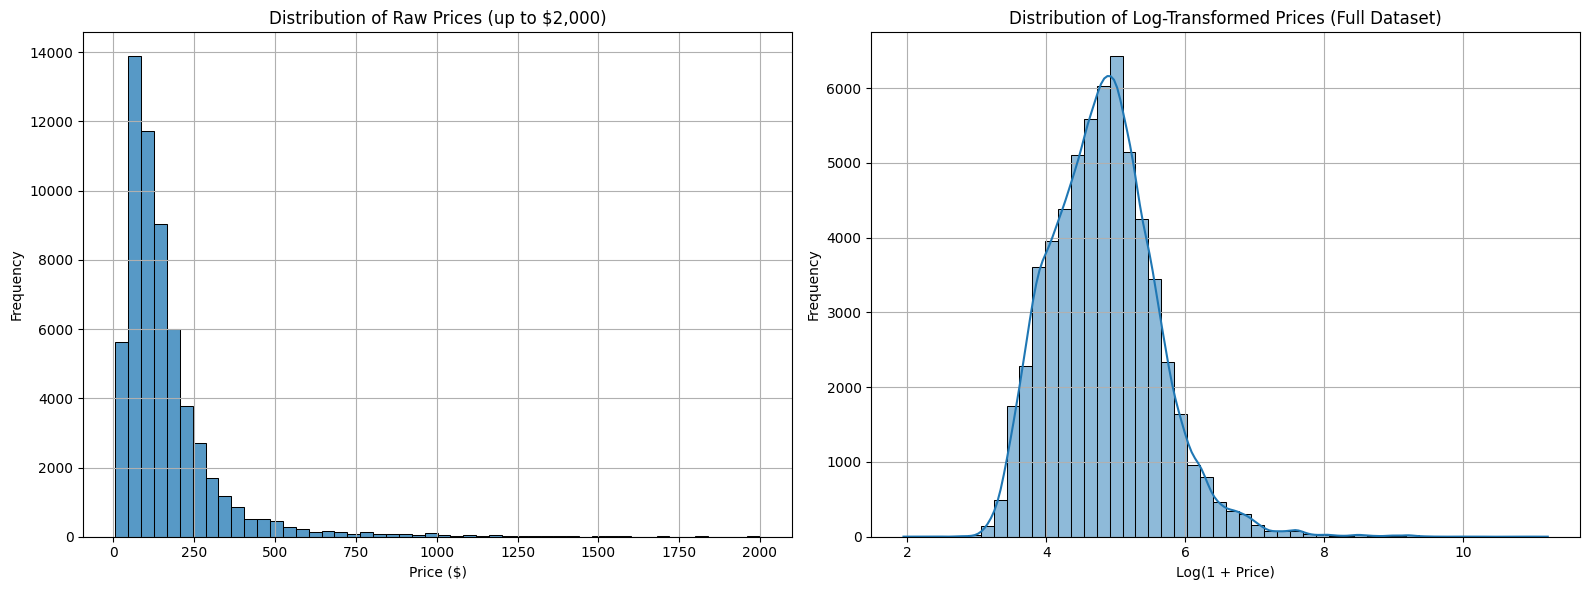

In [15]:
# Visualize the distribution of raw and log-transformed prices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Raw prices, filtered for better visualization
prices_for_viz = feature_df[feature_df['price'] < 2000]['price']
sns.histplot(prices_for_viz, bins=50, kde=False, ax=axes[0])
axes[0].set_title('Distribution of Raw Prices (up to $2,000)')
axes[0].set_xlabel('Price ($)')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Plot 2: Log-transformed prices of the entire dataset
log_prices = np.log1p(feature_df['price'])
sns.histplot(log_prices, bins=50, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Log-Transformed Prices (Full Dataset)')
axes[1].set_xlabel('Log(1 + Price)')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [20]:
feature_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60093 entries, 0 to 60092
Data columns (total 128 columns):
 #    Column                                           Dtype  
---   ------                                           -----  
 0    id                                               int64  
 1    price                                            float64
 2    accommodates                                     int64  
 3    bedrooms                                         float64
 4    beds                                             float64
 5    calculated_host_listings_count                   int64  
 6    has_availability                                 int64  
 7    host_acceptance_rate                             float64
 8    host_has_profile_pic                             int64  
 9    host_identity_verified                           int64  
 10   host_is_superhost                                int64  
 11   host_listings_count                              float64
 12   in

### Numerical Data

| Feature                                | Data Type |
|----------------------------------------|-----------|
| accommodates                           | int64     |
| bedrooms                               | float64   |
| beds                                   | float64   |
| calculated_host_listings_count         | int64     |
| has_availability                       | int64     |
| host_acceptance_rate                   | float64   |
| host_has_profile_pic                   | int64     |
| host_identity_verified                 | int64     |
| host_is_superhost                      | int64     |
| host_listings_count                    | float64   |
| instant_bookable                       | int64     |
| latitude                               | float64   |
| longitude                              | float64   |
| minimum_nights                         | int64     |
| number_of_reviews_ltm                  | int64     |
| review_scores_cleanliness              | float64   |
| review_scores_location                 | float64   |
| review_scores_rating                   | float64   |
| reviews_per_month                      | float64   |
| estimated_occupancy_l365d              | int64     |
| estimated_revenue_l365d                | float64   |
| availability_365                       | int64     |
| availability_90                        | int64     |
| availability_60                        | int64     |
| availability_30                        | int64     |
| is_unreviewed                          | int64     |
| days_since_last_review                 | int64     |
| days_as_host                           | int64     |





### Categorical & Complex Data

| Feature              | Data Type     |
|----------------------|---------------|
| neighbourhood_cleansed | Categorical   |
| property_type          | Categorical   |
| room_type              | Categorical   |
| amenities              | Complex (List) |




### NLP Features

| Feature                 | Data Type |
|-------------------------|-----------|
| average sentiment score | Numerical |
| sentiment score count   | Numerical |
| NLP embeddings          | Vector    |


Filtering for prices < $600. Using 60093 listings for this experiment.

Training the CatBoost model...
--- Final CatBoost Performance ---
Mean Absolute Error (MAE): 19.50
Mean Squared Error (MSE): 1,539.67
Root Mean Squared Error (RMSE): $39.24
R-squared (R²): 0.8520


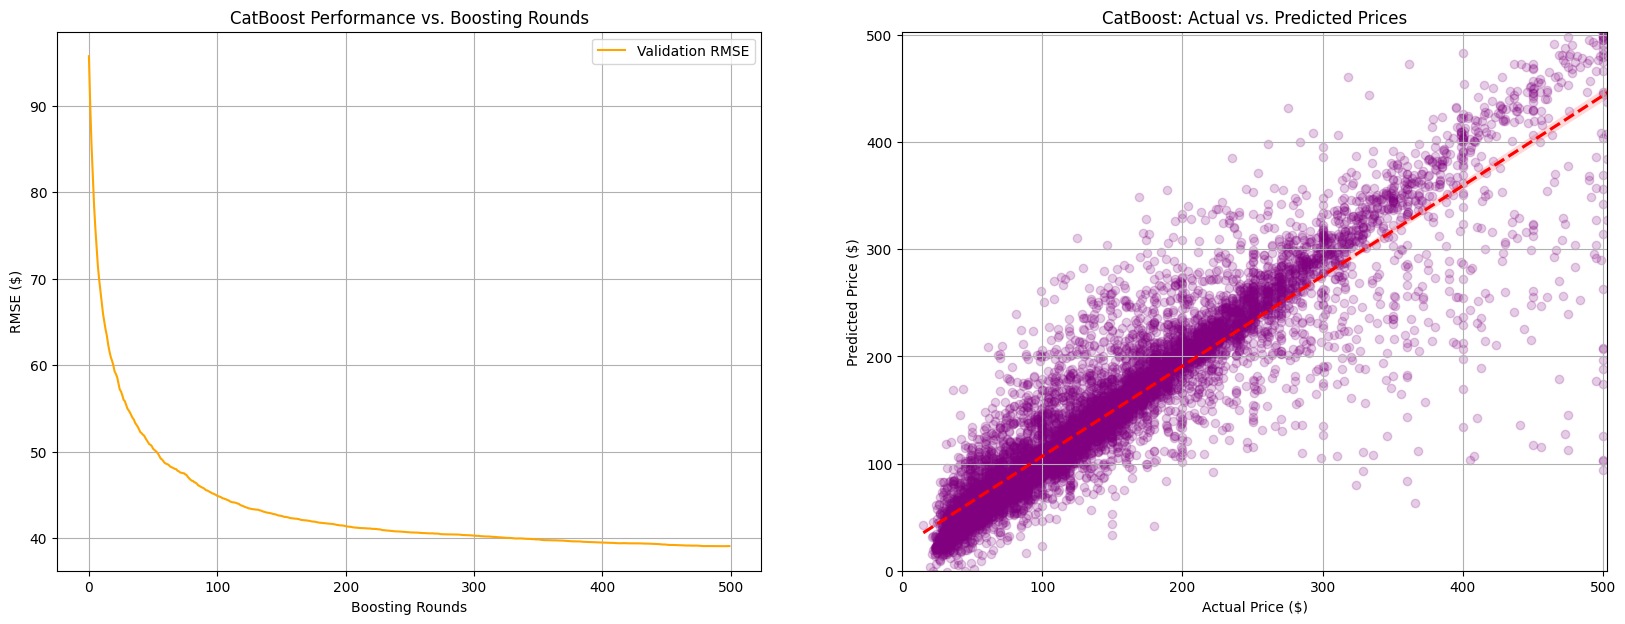

In [18]:
# Run a full experiment with CatBoost on a filtered dataset
n = 600

print(f"Filtering for prices < ${n:,}. Using {len(feature_df)} listings for this experiment.")
df_filtered = feature_df[feature_df['price'] < n].copy()

y = df_filtered['price']
X = df_filtered.drop(columns=['price', 'id'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_part, X_val, y_train_part, y_val = train_test_split(X_train_scaled, y_train, test_size=0.15, random_state=42)

catboost_model = cb.CatBoostRegressor(n_estimators=500, random_state=42, verbose=0)
print("\nTraining the CatBoost model...")
catboost_model.fit(
    X_train_part, y_train_part,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=20,
    verbose=False
)

y_pred = catboost_model.predict(X_test_scaled)

# Calculate performance metrics, including MSE
mae_cb = mean_absolute_error(y_test, y_pred)
mse_cb = mean_squared_error(y_test, y_pred)
rmse_cb = np.sqrt(mse_cb)
r2_cb = r2_score(y_test, y_pred)

print(f"--- Final CatBoost Performance ---")
print(f"Mean Absolute Error (MAE): {mae_cb:,.2f}")
print(f"Mean Squared Error (MSE): {mse_cb:,.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse_cb:,.2f}")
print(f"R-squared (R²): {r2_cb:.4f}")


# Generate Plots
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
eval_results = catboost_model.get_evals_result()
validation_rmse = eval_results['validation']['RMSE']
axes[0].plot(validation_rmse, label='Validation RMSE', color='orange')
axes[0].set_title('CatBoost Performance vs. Boosting Rounds')
axes[0].set_xlabel('Boosting Rounds')
axes[0].set_ylabel('RMSE ($)')
axes[0].grid(True)
axes[0].legend()

max_val = y_test.quantile(0.99)
sns.regplot(x=y_test, y=y_pred, ax=axes[1], scatter_kws={'alpha':0.2, 'color':'purple'}, line_kws={'color':'red', 'linestyle':'--'})
axes[1].set_title('CatBoost: Actual vs. Predicted Prices')
axes[1].set_xlabel('Actual Price ($)')
axes[1].set_ylabel('Predicted Price ($)')
axes[1].set_xlim(0, max_val)
axes[1].set_ylim(0, max_val)
axes[1].grid(True)
plt.show()